Configurações Iniciais

In [1]:
#Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Importar os dados
data = pd.read_csv('/content/dataarea2.csv', header=(0)) #arquivo gerado pelo notebook de agrupamento e limpeza

In [2]:
#ADICIONA COLUNAS PARA VÉSPERA E PÓS DIAS LETIVOS

#Separa os dados por dia
daily_data = data[['Ano', 'Mês', 'Dia_mês', 'dia letivo']].drop_duplicates()

#Ordena os dias
daily_data = daily_data.sort_values(by=['Ano', 'Mês', 'Dia_mês']).reset_index(drop=True)

#Aplica o deslocamento pra véspera no dataFrame diário
dia_letivo_amanha = daily_data['dia letivo'].shift(-1)
daily_data['véspera_de_dia_não_letivo'] = (dia_letivo_amanha == 0).astype(int)

#Aplica o deslocamento pra depois no dataFrame diário
dia_letivo_ontem = daily_data['dia letivo'].shift(1)
daily_data['pós_dia_não_letivo'] = (dia_letivo_ontem == 0).astype(int)

#Junta as tabelas
data = pd.merge(
    data,
    daily_data[['Ano', 'Mês', 'Dia_mês',
                'véspera_de_dia_não_letivo',
                'pós_dia_não_letivo']],
    on=['Ano', 'Mês', 'Dia_mês'],
    how='left'
)

In [3]:
#Aplicando One Hot Encoding nas variáveis categóricas
data = pd.get_dummies(data, columns=['Mês','Dia_semana','Dia_mês','prato_principal_1', 'prato_principal_2', 'guarnição', 'sobremesa_1'])

#Guardando os atributos
atributos = data.drop(columns=['Total']).columns

In [4]:
#R2 ajustado

n = len(data) #numero de observações
p = len(atributos) #numero de atributos
print(n)
print(p)

def r2_ajustado(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

519
210


Algoritmos de Previsão

In [5]:
#Importar bibliotecas

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

Fold 1: R² = 0.6349


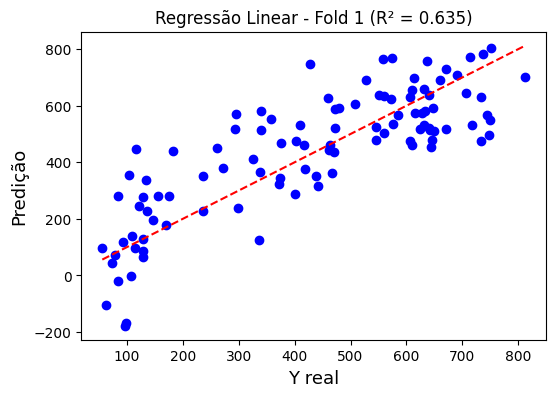

Fold 2: R² = 0.5924


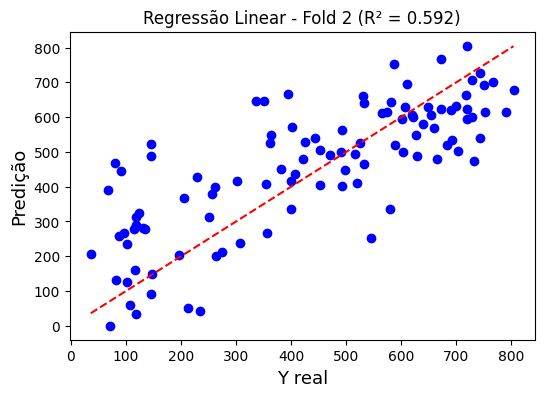

Fold 3: R² = 0.6666


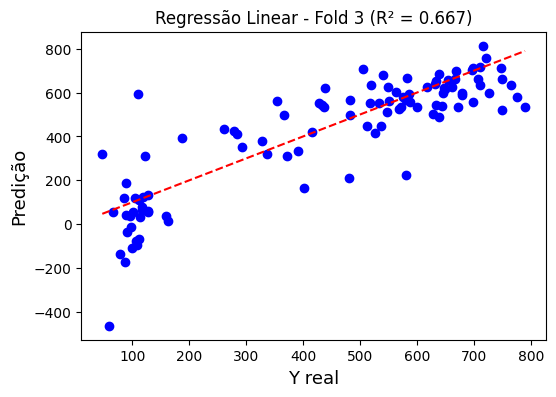

Fold 4: R² = 0.6819


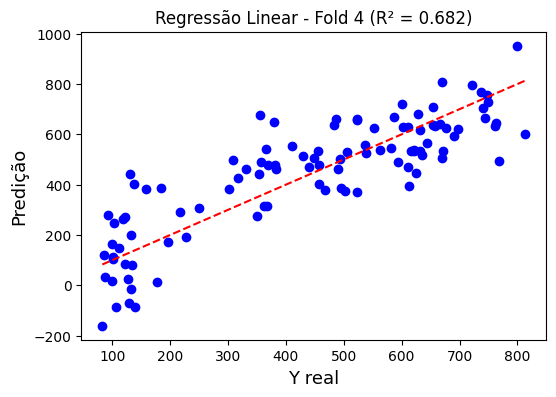

Fold 5: R² = 0.7390


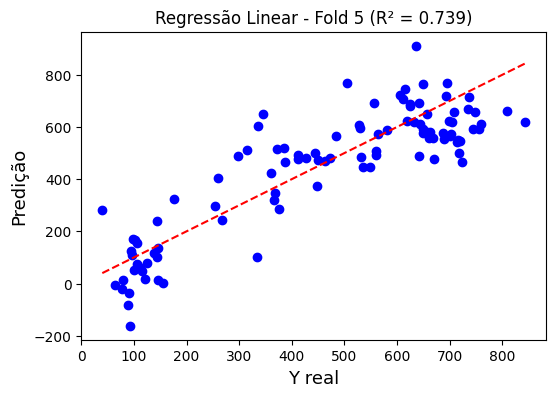


R² médio: 0.6629614081542906
Desvio padrão do R²: 0.0488404867560732


In [6]:
#----REGRESSÃO LINEAR MÚLTIPLA----


from sklearn.linear_model import LinearRegression


# valor a ser predito
ylabel = 'Total'

# separa y e X
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

# K-Fold externo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []
fold = 1

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lm = LinearRegression()
    lm.fit(X_train, y_train)

    y_pred = lm.predict(X_test)

    #Métricas
    R2 = r2_score(y_test, y_pred)
    lista_r2.append(R2)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: R² = {R2:.4f}")

    # ---- Plot ----
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, color='blue')
    plt.xlabel("Y real", fontsize=13)
    plt.ylabel("Predição", fontsize=13)
    plt.title(f"Regressão Linear - Fold {fold} (R² = {R2:.3f})")

    # linha y=x
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')

    plt.show()

    fold += 1

r2_reg_lin_mult = np.mean(lista_r2)
r2_dp_reg_lin_mult = np.std(lista_r2)
rmse_reg_lin_mult = np.mean(lista_rmse)
rmse_dp_reg_lin_mult = np.std(lista_rmse)
print("\nR² médio:", r2_reg_lin_mult)
print("Desvio padrão do R²:", r2_dp_reg_lin_mult)

Fold 1: hiperparâmetro alpha escolhido = 1.15949, R2 = 0.8264


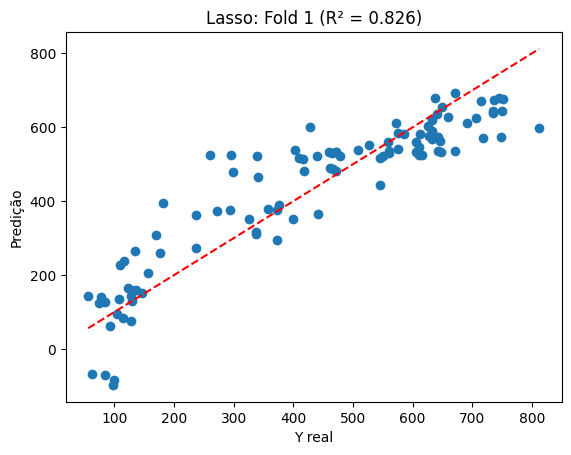

Fold 2: hiperparâmetro alpha escolhido = 0.71582, R2 = 0.7555


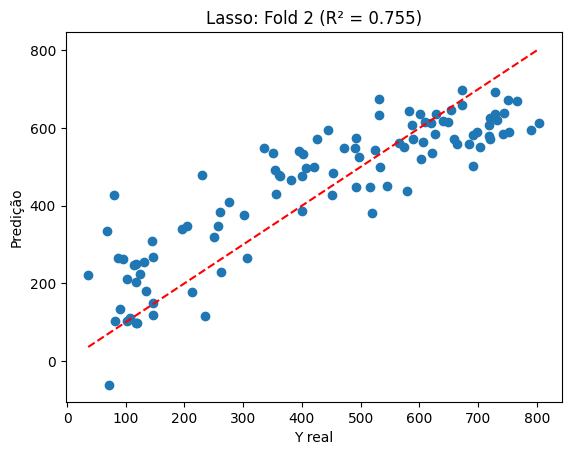

Fold 3: hiperparâmetro alpha escolhido = 0.84594, R2 = 0.8033


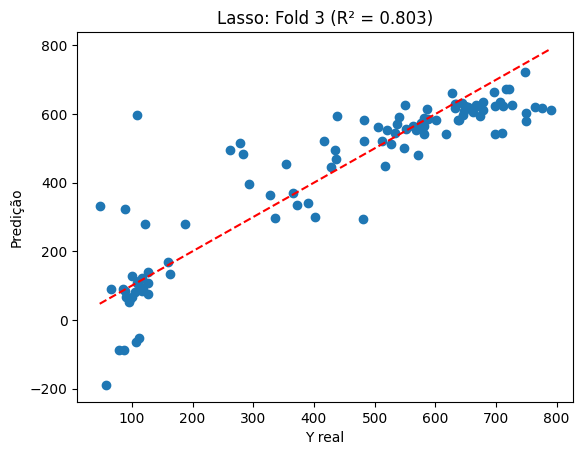

Fold 4: hiperparâmetro alpha escolhido = 1.03816, R2 = 0.8146


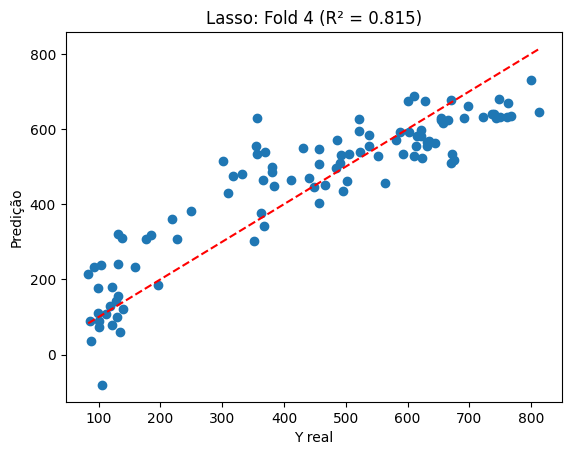

Fold 5: hiperparâmetro alpha escolhido = 1.18400, R2 = 0.8293


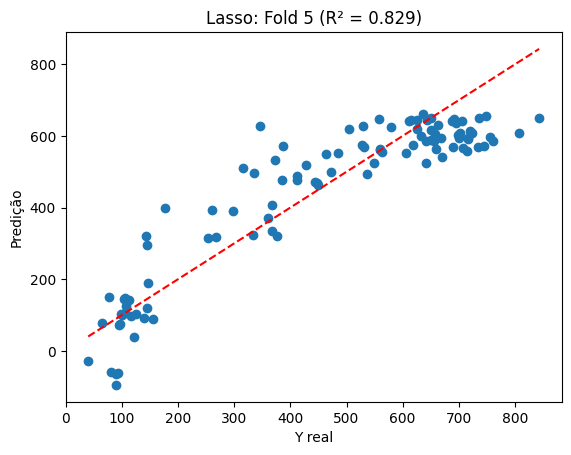


R2 médio no K-Fold: 0.8058086200850733
Desvio padrão do R2: 0.026793819391938617


In [7]:
#---LASSO---

from sklearn.linear_model import LassoCV

# valor a ser predito
ylabel = 'Total'

# separa y e X
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

# K-Fold externo
kf = KFold(n_splits=5, shuffle=True,random_state=42)

lista_r2 = [] # para armezar o R2 de cada fold
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):

    # separa treino e teste do fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # LassoCV calcula o melhor alpha usando k-fold interno nos dados de treino do k-fold externo
    lasso = LassoCV(cv=5, max_iter=100000,random_state=42)
    lasso.fit(X_train, y_train)

    # previsão no teste
    y_pred = lasso.predict(X_test)

    # Métricas
    R2 = r2_score(y_test, y_pred)
    lista_r2.append(R2)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: hiperparâmetro alpha escolhido = {lasso.alpha_:.5f}, R2 = {R2:.4f}")

    # ---- Plot do fold ----
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Lasso: Fold {fold} (R² = {R2:.3f})")

    # linha y=x
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.show()

    fold += 1

# Média dos R2 ao final
r2_lasso = np.mean(lista_r2)
r2_dp_lasso = np.std(lista_r2)
rmse_lasso = np.mean(lista_rmse)
rmse_dp_lasso = np.std(lista_rmse)
print("\nR2 médio no K-Fold:", r2_lasso)
print("Desvio padrão do R2:", r2_dp_lasso)

Fold 1: R2 = 0.8659, RMSE = 81.123


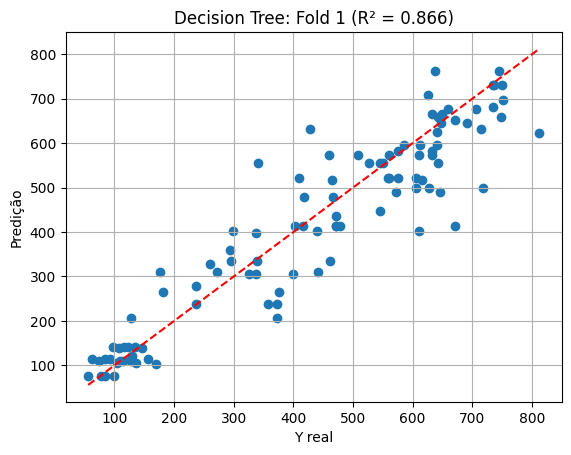

Fold 2: R2 = 0.7875, RMSE = 105.562


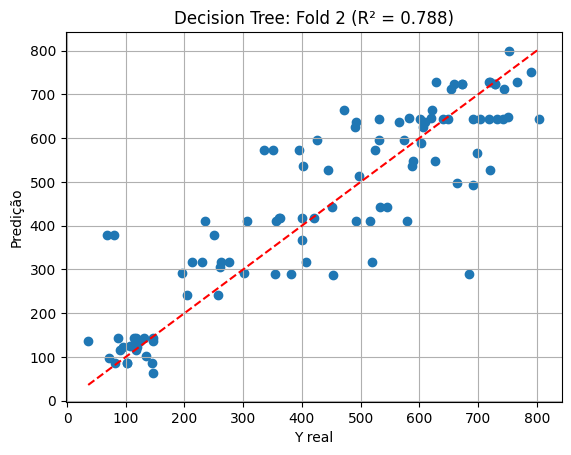

Fold 3: R2 = 0.8052, RMSE = 105.056


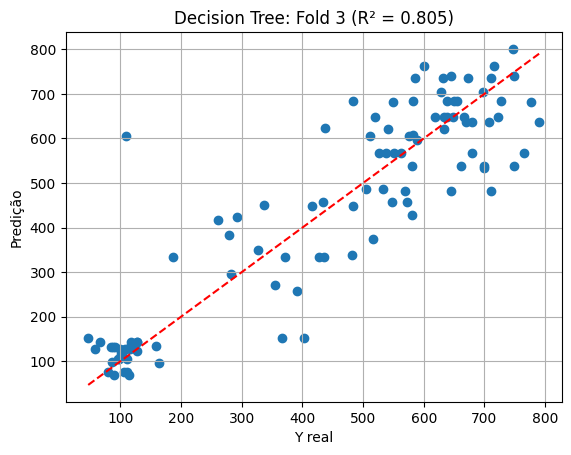

Fold 4: R2 = 0.8132, RMSE = 96.209


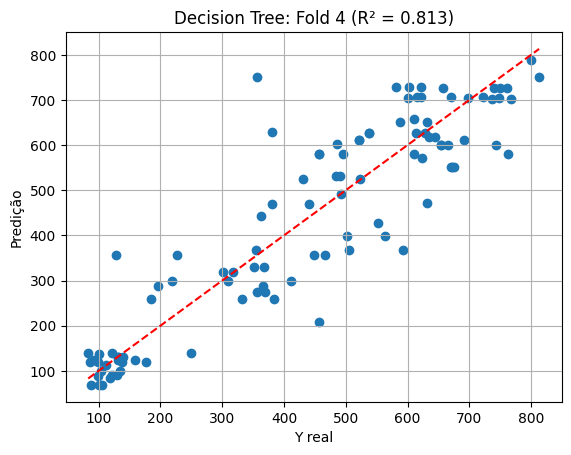

Fold 5: R2 = 0.7918, RMSE = 108.426


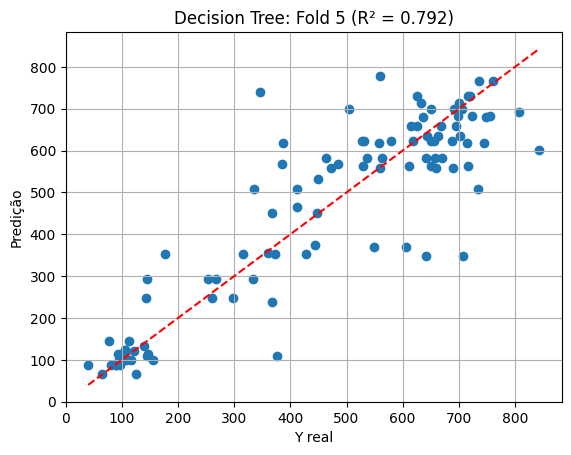


R2 médio no K-Fold: 0.8127205579823403
Desvio padrão do R2: 0.02813349098839756


In [8]:
# --- Decision Tree Regressor ---

from sklearn.tree import DecisionTreeRegressor

ylabel = 'Total'

# separa y e X
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

# K-Fold externo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #ajuste dos hiperparâmetros
    tree = DecisionTreeRegressor(
        max_depth=15,           # controla a profundidade da árvore
        min_samples_split=10,   # exige pelo menos 10 amostras para dividir um nó
        min_samples_leaf=4,     # cada folha precisa ter pelo menos 4 amostras
        random_state=42
    )
    tree.fit(X_train, y_train)

    y_pred = tree.predict(X_test)

    # métricas
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot do fold ---
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Decision Tree: Fold {fold} (R² = {R2:.3f})")

    # linha y=x
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.grid(True)
    plt.show()

    fold += 1

r2_decision_tree = np.mean(lista_r2)
r2_dp_decision_tree = np.std(lista_r2)
rmse_decision_tree = np.mean(lista_rmse)
rmse_dp_decision_tree = np.std(lista_rmse)
print("\nR2 médio no K-Fold:", r2_decision_tree)
print("Desvio padrão do R2:", r2_dp_decision_tree)

Fold 1: R2 = 0.8697, RMSE = 79.980


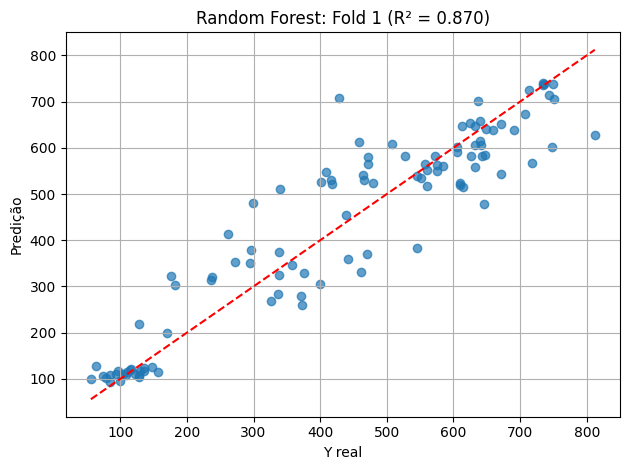

Fold 2: R2 = 0.8310, RMSE = 94.143


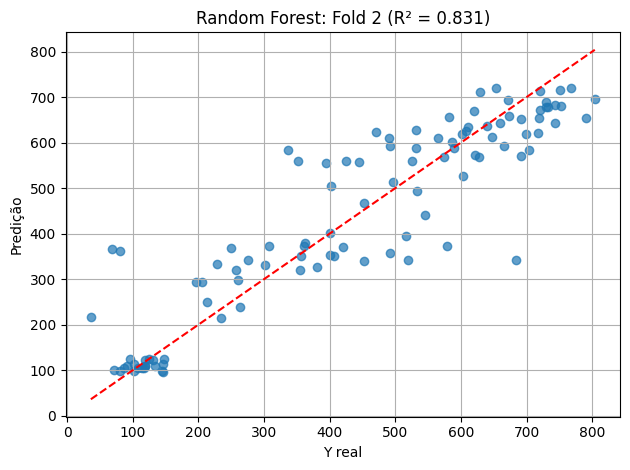

Fold 3: R2 = 0.8805, RMSE = 82.306


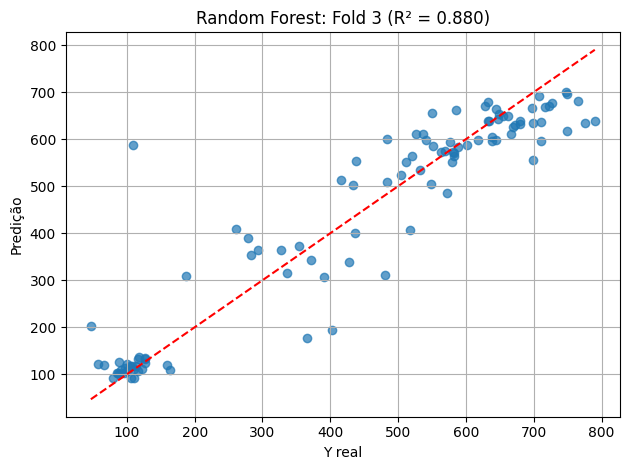

Fold 4: R2 = 0.8677, RMSE = 80.949


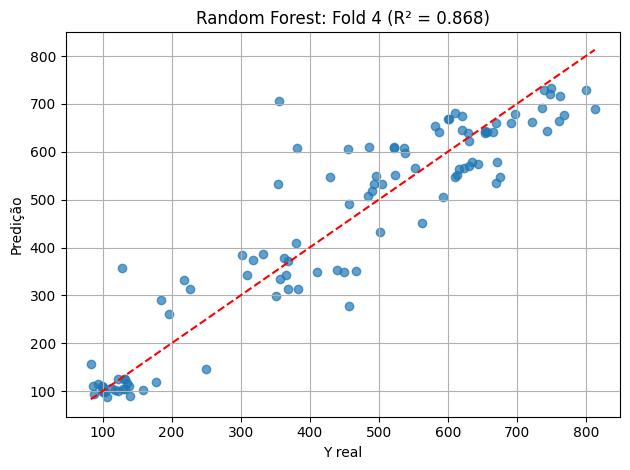

Fold 5: R2 = 0.8538, RMSE = 90.860


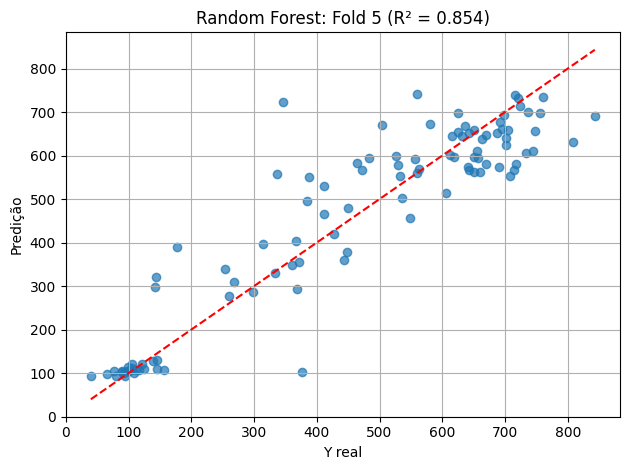


R2 médio no K-Fold: 0.860525421250777
Desvio padrão do R2: 0.01702814935283324


In [9]:
# --- Random Forest Regressor ---

from sklearn.ensemble import RandomForestRegressor

ylabel = 'Total'

# separa y e X
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

# K-Fold externo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):
    # separa treino e teste do fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # modelo Random Forest
    rf = RandomForestRegressor(
        n_estimators=300,      # número de árvores
        max_depth=30,        # limitar a profundidade
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
    )

    rf.fit(X_train, y_train)

    # previsão
    y_pred = rf.predict(X_test)

    # métricas
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot do fold ---
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Random Forest: Fold {fold} (R² = {R2:.3f})")
    plt.grid(True)

    # linha y = x
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.tight_layout()
    plt.show()

    fold += 1

# Resultados finais

r2_random_forest = np.mean(lista_r2)
r2_dp_random_forest = np.std(lista_r2)
rmse_random_forest = np.mean(lista_rmse)
rmse_dp_random_forest = np.std(lista_rmse)
print("\nR2 médio no K-Fold:", r2_random_forest)
print("Desvio padrão do R2:", r2_dp_random_forest)

Fold 1: alpha = 79.24829, R2 = 0.7623, RMSE = 108.008


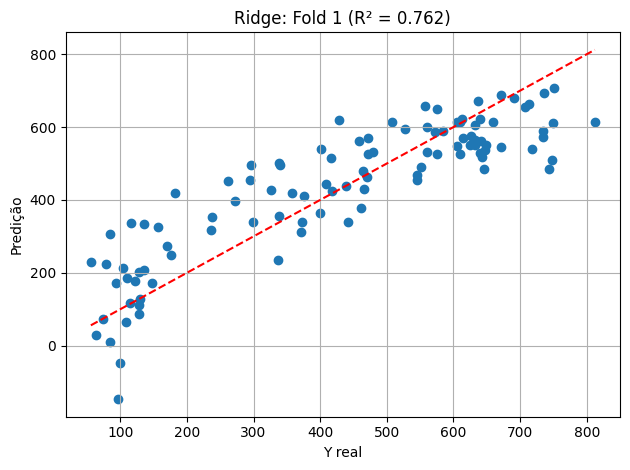

Fold 2: alpha = 95.45485, R2 = 0.6338, RMSE = 138.572


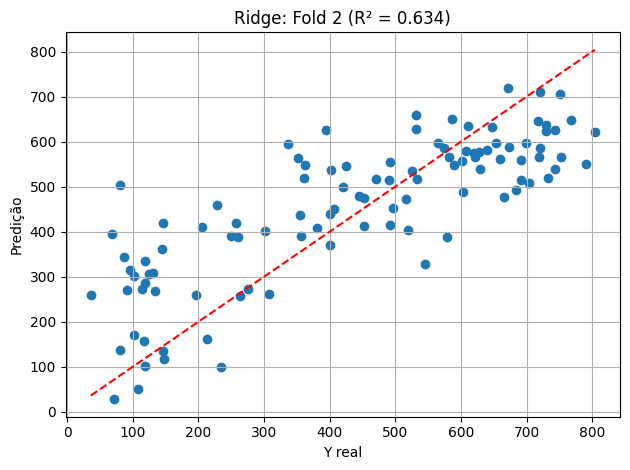

Fold 3: alpha = 79.24829, R2 = 0.7606, RMSE = 116.473


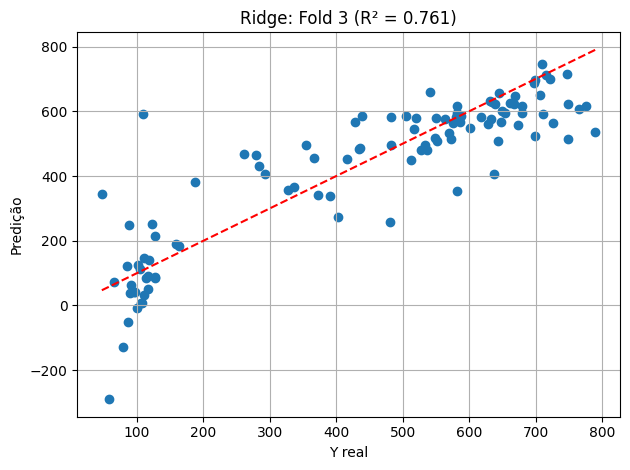

Fold 4: alpha = 95.45485, R2 = 0.7665, RMSE = 107.542


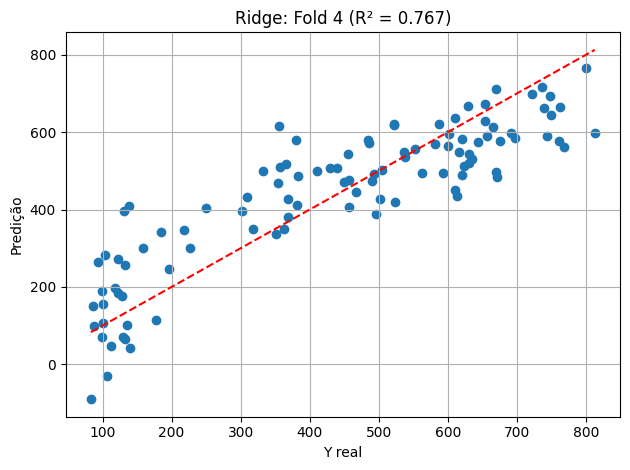

Fold 5: alpha = 114.97570, R2 = 0.7813, RMSE = 111.127


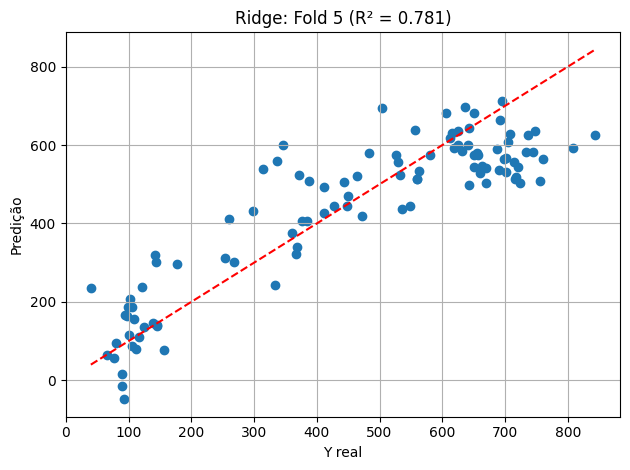


R2 médio no K-Fold: 0.7409136282060464
Desvio padrão do R2: 0.054039060656896995


In [10]:
# --- RIDGE REGRESSION ---

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

ylabel = 'Total'

# separa y e X
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

# K-Fold externo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):

    # separa treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # RidgeCV
    ridge = make_pipeline(
        StandardScaler(),
        RidgeCV(alphas=np.logspace(-4, 4, 100), cv=5)  # faz cv para escolher alpha
    )

    ridge.fit(X_train, y_train)

    # previsão
    y_pred = ridge.predict(X_test)

    # métricas
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    # alpha escolhido
    alpha_escolhido = ridge.named_steps['ridgecv'].alpha_

    print(f"Fold {fold}: alpha = {alpha_escolhido:.5f}, R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot do fold ---
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Ridge: Fold {fold} (R² = {R2:.3f})")

    # linha y = x
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

# Resultados

r2_ridge = np.mean(lista_r2)
r2_dp_ridge = np.std(lista_r2)
rmse_ridge = np.mean(lista_rmse)
rmse_dp_ridge = np.std(lista_rmse)

print("\nR2 médio no K-Fold:", r2_ridge)
print("Desvio padrão do R2:", r2_dp_ridge)

Fold 1: alpha = 4.83293, l1_ratio = 1.00, R2 = 0.8141, RMSE = 95.526


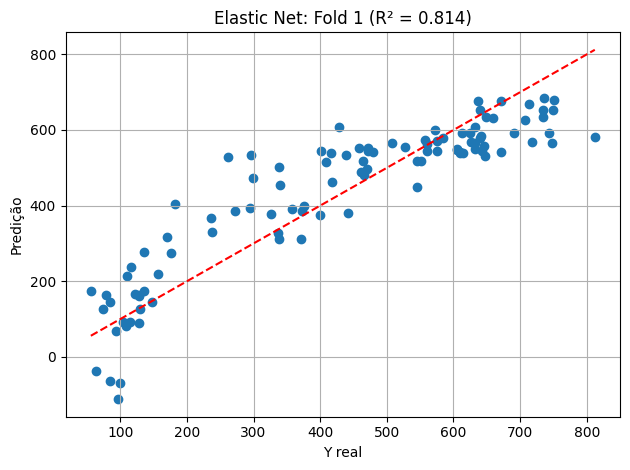

Fold 2: alpha = 4.83293, l1_ratio = 1.00, R2 = 0.7611, RMSE = 111.918


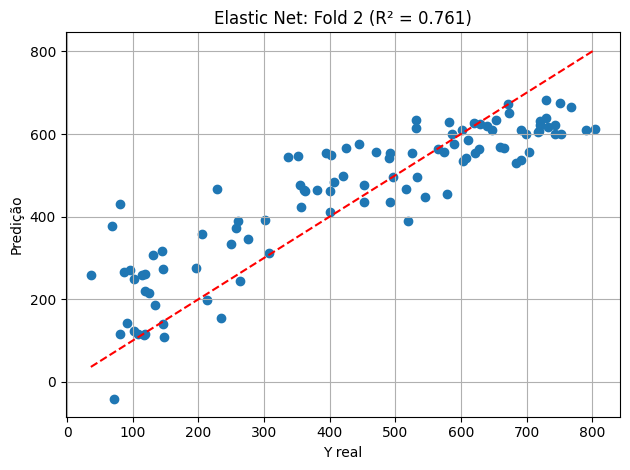

Fold 3: alpha = 4.83293, l1_ratio = 1.00, R2 = 0.8036, RMSE = 105.507


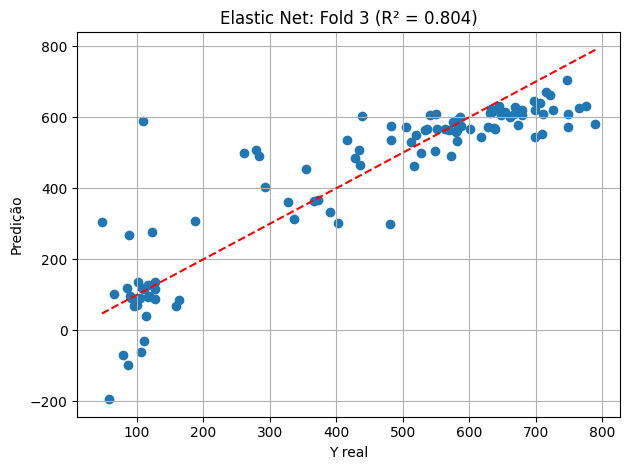

Fold 4: alpha = 4.83293, l1_ratio = 1.00, R2 = 0.8174, RMSE = 95.120


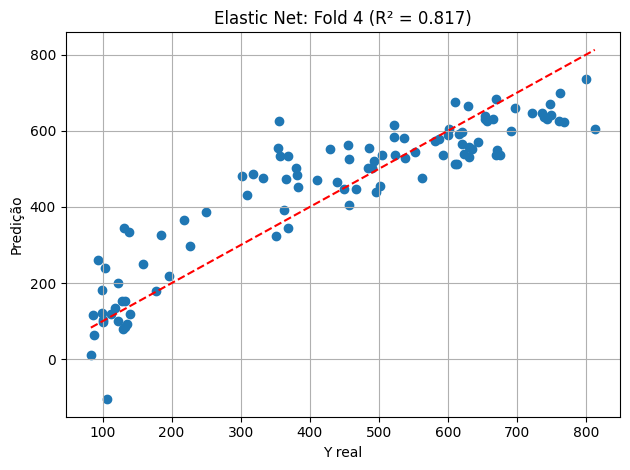

Fold 5: alpha = 4.83293, l1_ratio = 1.00, R2 = 0.8272, RMSE = 98.781


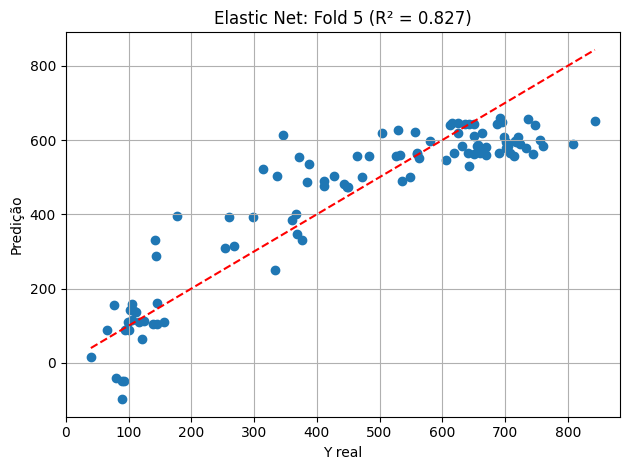


R2 médio no K-Fold: 0.8046636363416674
Desvio padrão do R2: 0.023033452272254326


In [11]:
# --- ELASTIC NET REGRESSION ---

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

ylabel = 'Total'

# separa y e X
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

# K-Fold externo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):

    # separa treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # modelo com pipeline (padronização + ElasticNetCV)
    elastic = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            l1_ratio=[0.2, 0.5, 0.8, 1],   # proporção entre L1 e L2
            alphas=np.logspace(-3, 2, 20), # força da regularização
            cv=5,                           # validação cruzada interna para escolher alpha e l1_ratio
            max_iter=100000,
            random_state=42
        )
    )

    elastic.fit(X_train, y_train)

    # previsão
    y_pred = elastic.predict(X_test)

    # métricas
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    # parâmetros escolhidos
    modelo_cv = elastic.named_steps['elasticnetcv']
    print(f"Fold {fold}: alpha = {modelo_cv.alpha_:.5f}, l1_ratio = {modelo_cv.l1_ratio_:.2f}, R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot do fold ---
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Elastic Net: Fold {fold} (R² = {R2:.3f})")

    # linha y = x
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

# Resultados

r2_elastic_net = np.mean(lista_r2)
r2_dp_elastic_net = np.std(lista_r2)
rmse_elastic_net = np.mean(lista_rmse)
rmse_dp_elastic_net = np.std(lista_rmse)

print("\nR2 médio no K-Fold:", r2_elastic_net)
print("Desvio padrão do R2:", r2_dp_elastic_net)

Fold 1: R2 = 0.8714, RMSE = 79.439


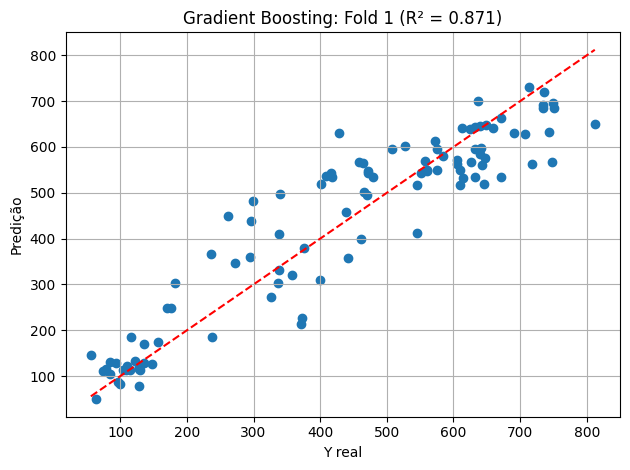

Fold 2: R2 = 0.8300, RMSE = 94.415


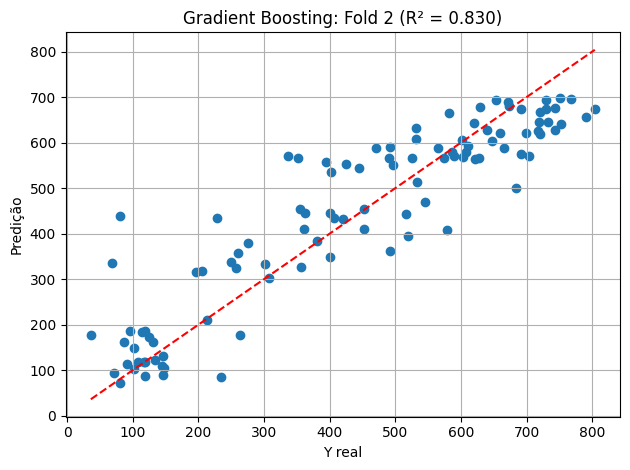

Fold 3: R2 = 0.8607, RMSE = 88.845


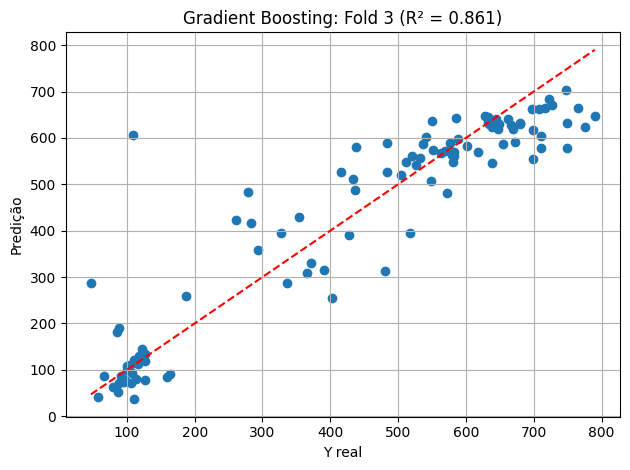

Fold 4: R2 = 0.8694, RMSE = 80.426


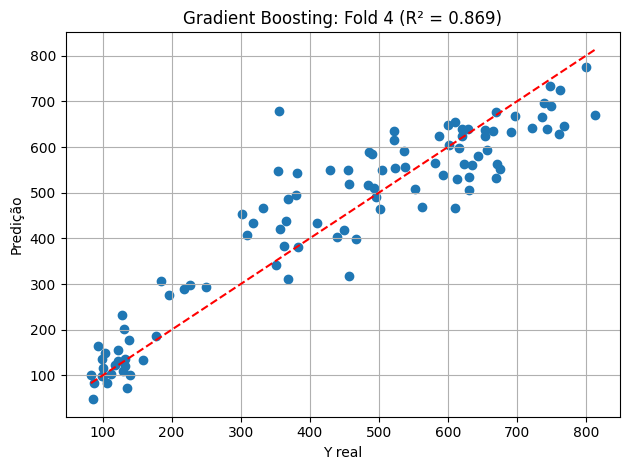

Fold 5: R2 = 0.8730, RMSE = 84.682


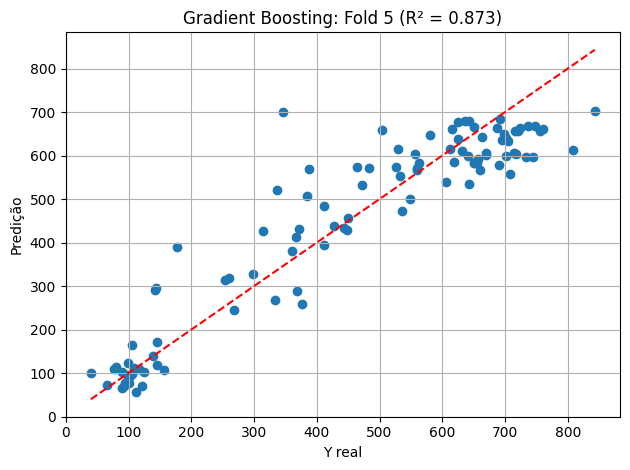


R2 médio no K-Fold: 0.8609131085140369
Desvio padrão do R2: 0.01602507232047368


In [12]:
# --- GRADIENT BOOSTING REGRESSOR ---

from sklearn.ensemble import GradientBoostingRegressor

ylabel = 'Total'
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gb = GradientBoostingRegressor(
        n_estimators=200,      # número de árvores
        learning_rate=0.05,    # taxa de aprendizado
        max_depth=3,           # profundidade das árvores
        subsample=0.8,         # amostragem parcial para evitar overfitting
        random_state=42
    )

    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot ---
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Gradient Boosting: Fold {fold} (R² = {R2:.3f})")
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

r2_gradient_boosting = np.mean(lista_r2)
r2_dp_gradient_boosting = np.std(lista_r2)
rmse_gradient_boosting = np.mean(lista_rmse)
rmse_dp_gradient_boosting = np.std(lista_rmse)

print("\nR2 médio no K-Fold:", r2_gradient_boosting)
print("Desvio padrão do R2:", r2_dp_gradient_boosting)

Fold 1: R2 = 0.8711, RMSE = 79.546


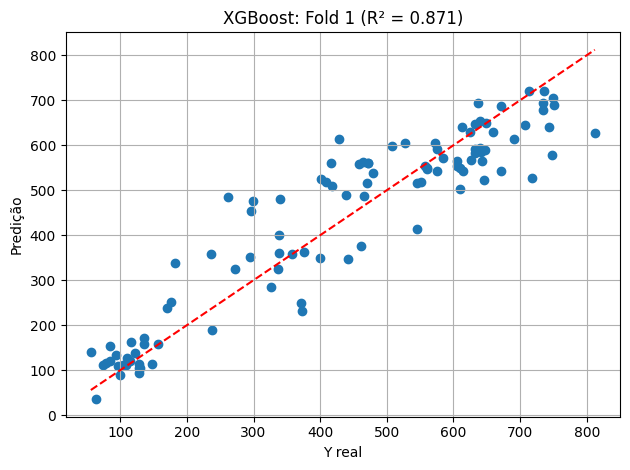

Fold 2: R2 = 0.8316, RMSE = 93.965


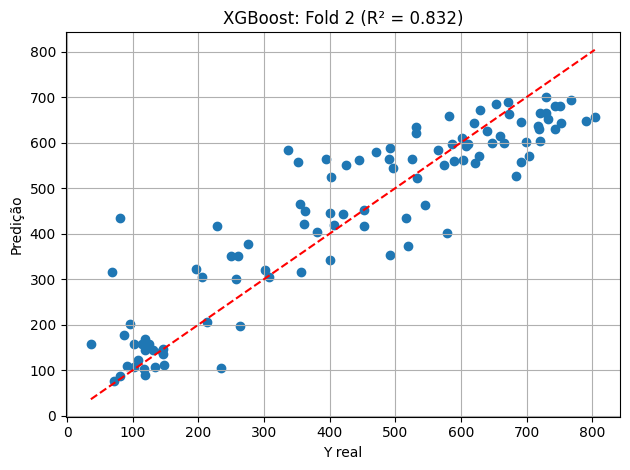

Fold 3: R2 = 0.8690, RMSE = 86.161


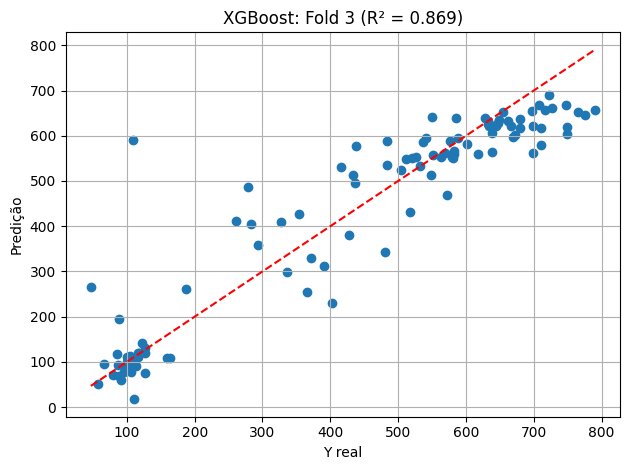

Fold 4: R2 = 0.8681, RMSE = 80.832


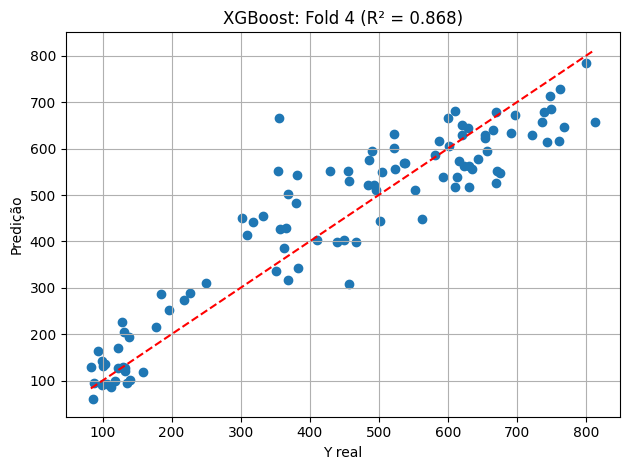

Fold 5: R2 = 0.8740, RMSE = 84.366


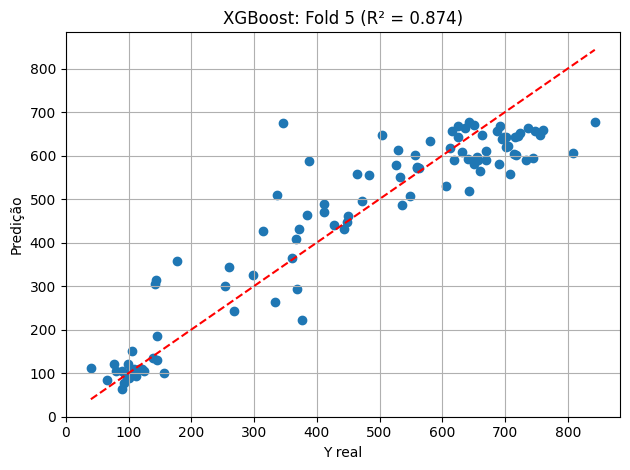


R2 médio no K-Fold: 0.8627503501591669
Desvio padrão do R2: 0.015689927835462567


In [13]:
# --- XGBOOST REGRESSOR ---

from xgboost import XGBRegressor

ylabel = 'Total'
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modelo XGBoost
    xgb = XGBRegressor(
        n_estimators=200,       # número de árvores
        learning_rate=0.05,     # taxa de aprendizado
        max_depth=3,            # profundidade máxima das árvores
        subsample=0.8,          # fração de amostras usadas em cada árvore
        colsample_bytree=0.8,   # fração de features usadas em cada árvore
        random_state=42,
        objective='reg:squarederror',  # função de perda para regressão
        n_jobs=-1               # usa todos os núcleos disponíveis
    )

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot ---
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"XGBoost: Fold {fold} (R² = {R2:.3f})")
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

r2_xgboost = np.mean(lista_r2)
r2_dp_xgboost = np.std(lista_r2)
rmse_xgboost = np.mean(lista_rmse)
rmse_dp_xgboost = np.std(lista_rmse)
print("\nR2 médio no K-Fold:", r2_xgboost)
print("Desvio padrão do R2:", r2_dp_xgboost)

Fold 1: R2 = 0.8271, RMSE = 92.114


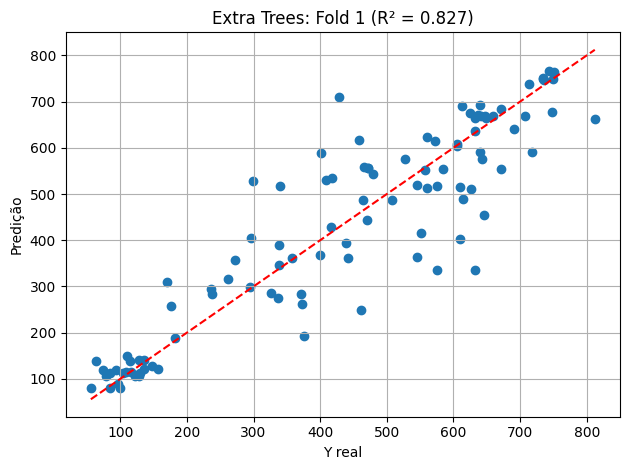

Fold 2: R2 = 0.7253, RMSE = 120.026


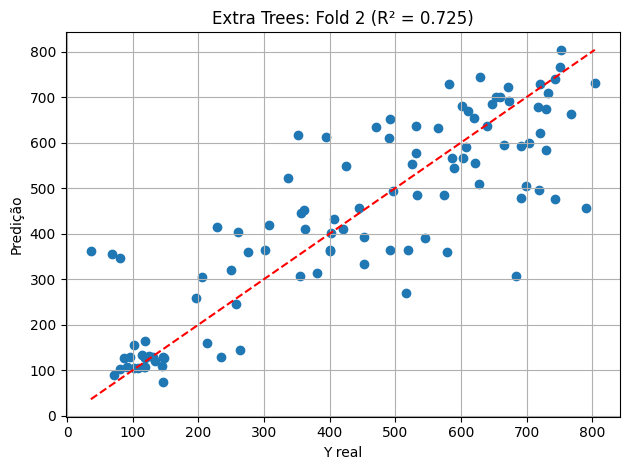

Fold 3: R2 = 0.8500, RMSE = 92.192


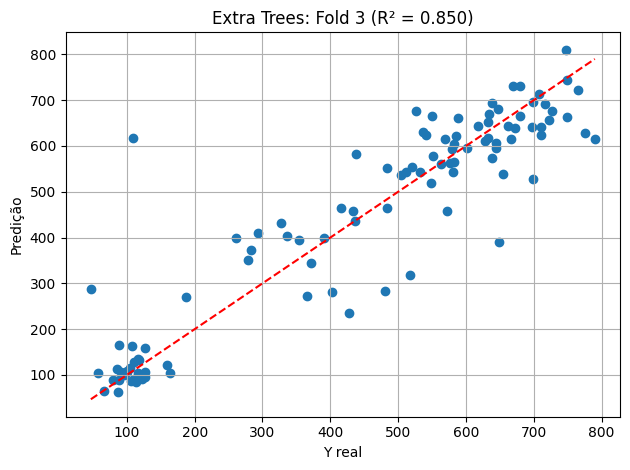

Fold 4: R2 = 0.8409, RMSE = 88.789


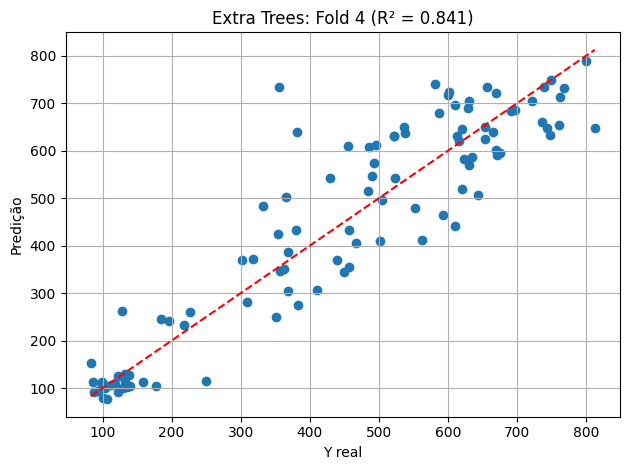

Fold 5: R2 = 0.8483, RMSE = 92.561


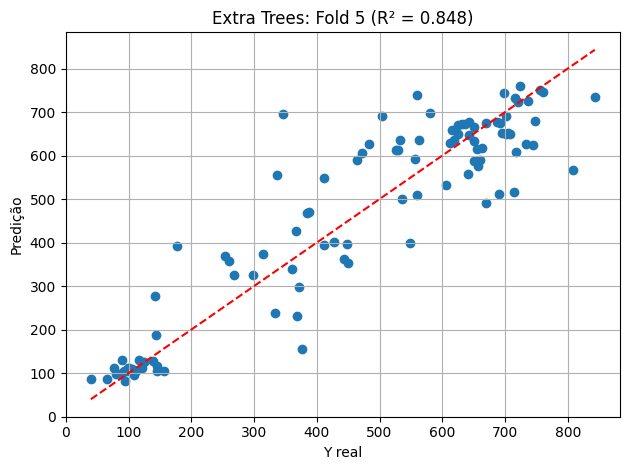


R2 médio no K-Fold: 0.8183075774931596
Desvio padrão do R2: 0.04720876128875344


In [14]:
# --- EXTRA TREES REGRESSOR ---

from sklearn.ensemble import ExtraTreesRegressor


ylabel = 'Total'
y = data[ylabel].to_numpy()
X = data.drop(columns=[ylabel]).to_numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lista_r2 = []
lista_rmse = []

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modelo Extra Trees
    et = ExtraTreesRegressor(
        n_estimators=200,     # número de árvores
        max_depth=None,       # profundidade máxima
        min_samples_split=2,  # mínimo de amostras para dividir um nó
        min_samples_leaf=1,   # mínimo de amostras por folha
        max_features=None,    # número de features consideradas por split
        bootstrap=False,      # usa toda a amostra em vez de bootstrap
        random_state=42,
        n_jobs=-1             # usa todos os núcleos disponíveis
    )

    et.fit(X_train, y_train)
    y_pred = et.predict(X_test)

    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    lista_r2.append(R2)
    lista_rmse.append(RMSE)

    print(f"Fold {fold}: R2 = {R2:.4f}, RMSE = {RMSE:.3f}")

    # --- Plot ---
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Y real")
    plt.ylabel("Predição")
    plt.title(f"Extra Trees: Fold {fold} (R² = {R2:.3f})")
    xl = np.linspace(min(y_test), max(y_test), 50)
    plt.plot(xl, xl, 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

r2_extra_trees = np.mean(lista_r2)
r2_dp_extra_trees = np.std(lista_r2)
rmse_extra_trees = np.mean(lista_rmse)
rmse_dp_extra_trees = np.std(lista_rmse)
print("\nR2 médio no K-Fold:", r2_extra_trees)
print("Desvio padrão do R2:", r2_dp_extra_trees)

R2 ajustado nos modelos lineares (treinado no modelo inteiro)

In [15]:
from sklearn.linear_model import Lasso #anteriomente usou-se LassoCV
from sklearn.linear_model import Ridge #anteriomente usou-se RidgeCV
from sklearn.linear_model import ElasticNet #anteriomente usou-se ElasticNetCV

X = data.drop(columns=['Total'])
y = data['Total']

modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)
r2_semcv_rl = r2_score(y, y_pred)
r2_adj_rl = r2_ajustado(r2_semcv_rl, n, p)

alpha_lasso = lasso.alpha_
modelo = Lasso(alpha=alpha_lasso)
modelo.fit(X, y)
y_pred = modelo.predict(X)
r2_semcv_lasso = r2_score(y, y_pred)
r2_adj_lasso = r2_ajustado(r2_semcv_lasso, n, p)

alpha_ridge = ridge.named_steps['ridgecv'].alpha_
modelo = Ridge(alpha=alpha_ridge)
modelo.fit(X, y)
y_pred = modelo.predict(X)
r2_semcv_ridge = r2_score(y, y_pred)
r2_adj_ridge = r2_ajustado(r2_semcv_ridge, n, p)

alpha_en = elastic.named_steps['elasticnetcv'].alpha_
l1_ratio_en = elastic.named_steps['elasticnetcv'].l1_ratio_
modelo = ElasticNet(alpha=alpha_en, l1_ratio=l1_ratio_en, max_iter=10000)
modelo.fit(X, y)
y_pred = modelo.predict(X)
r2_semcv_en = r2_score(y, y_pred)
r2_adj_en = r2_ajustado(r2_semcv_en, n, p)

O R2 com CV mede capacidade de generalização. O R2 sem CV mede qualidade de ajuste/aderência do modelo aos dados observados.

In [16]:
#COMPARAR ALGORITMOS

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

resultados = {
    'Modelo': [
        'Regressão Linear', 'Lasso', 'Decision Tree', 'Random Forest',
        'Ridge', 'Elastic Net', 'Gradient Boosting', 'XGBoost', 'Extra Trees'
    ],
    'R² médio (com CV)': [
        r2_reg_lin_mult, r2_lasso, r2_decision_tree, r2_random_forest,
        r2_ridge, r2_elastic_net, r2_gradient_boosting, r2_xgboost, r2_extra_trees
    ],
    'R² DP': [
        r2_dp_reg_lin_mult, r2_dp_lasso, r2_dp_decision_tree, r2_dp_random_forest,
        r2_dp_ridge, r2_dp_elastic_net, r2_dp_gradient_boosting, r2_dp_xgboost, r2_dp_extra_trees
    ],
    'RMSE médio': [
        rmse_reg_lin_mult, rmse_lasso, rmse_decision_tree, rmse_random_forest,
        rmse_ridge, rmse_elastic_net, rmse_gradient_boosting, rmse_xgboost, rmse_extra_trees
    ],
    'RMSE DP': [
        rmse_dp_reg_lin_mult, rmse_dp_lasso, rmse_dp_decision_tree, rmse_dp_random_forest,
        rmse_dp_ridge, rmse_dp_elastic_net, rmse_dp_gradient_boosting, rmse_dp_xgboost, rmse_dp_extra_trees
    ],
    'R² (sem CV)': [
        r2_semcv_rl, r2_semcv_lasso, np.nan,
        np.nan, r2_semcv_ridge, r2_semcv_en,
        np.nan, np.nan, np.nan
    ],
    'R² ajustado': [
        r2_adj_rl, r2_adj_lasso, np.nan,
        np.nan, r2_adj_ridge, r2_adj_en,
        np.nan, np.nan, np.nan
    ]
}

tabela = pd.DataFrame(resultados)
display(tabela.round(5))

,Modelo,R² médio (com CV),R² DP,RMSE médio,RMSE DP,R² (sem CV),R² ajustado
0,Regressão Linear,0.66296,0.04884,132.88758,8.77776,0.89739,0.82742
1,Lasso,0.80581,0.02679,101.02820,7.49538,0.83745,0.72663
2,Decision Tree,0.81272,0.02813,99.27521,9.95554,NaN,NaN
3,Random Forest,0.86053,0.01703,85.64761,5.73966,NaN,NaN
4,Ridge,0.74091,0.05404,116.34437,11.56113,0.68171,0.46470
5,Elastic Net,0.80466,0.02303,101.37053,6.45435,0.78136,0.63228
6,Gradient Boosting,0.86091,0.01603,85.56136,5.54606,NaN,NaN
7,XGBoost,0.86275,0.01569,84.97381,5.08394,NaN,NaN
8,Extra Trees,0.81831,0.04721,97.13641,11.52601,NaN,NaN


Treinar o modelo com o dataset inteiro para novas previsões

In [17]:
#Modelo Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
        n_estimators=200,      # número de árvores
        learning_rate=0.05,    # taxa de aprendizado
        max_depth=3,           # profundidade das árvores
        subsample=0.8,         # amostragem parcial para evitar overfitting
        random_state=42
    )

gb.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42,
                          subsample=0.8)

In [18]:
#---OBSERVAÇÕES ESPECÍFICAS---

nova_obs = pd.DataFrame({
    'Precipitacao_mm':[0],
    'Temp_max_C':[25],
    'Temp_min_C':[20],
    'Umid_rel_ar':[50],
    'Vento_velocidade_horaria (m/s)': [3],
    'Vento_rajada_maxima (m/s)': [3],
    'Dia_mês': ['25'],
    'Dia_semana': ['ter'],
    'Mês': ['5'],
    'prato_principal_1':['lasanha à bolonhesa'],
    'prato_principal_2': ['curry de legumes'],
    'guarnição': ['legumes sautê'],
    'sobremesa_1': ['goiabada'],
    'dia letivo' : [1],
    'véspera_de_dia_não_letivo' : [0],
    'pós_dia_não_letivo' : [0]
})

nova_obs = pd.get_dummies(nova_obs)
# Reindexa para garantir mesmo formato do treino
nova_obs = nova_obs.reindex(columns=atributos, fill_value=0)

print("Predição gradient boosting:", gb.predict(nova_obs))
print('\n')

Predição gradient boosting: [593.09245448]


